In [1]:
import pennylane as qml
from pennylane import numpy as np
import scipy
import matplotlib.pyplot as plt
from globalVars import *
from model_3qubit import *

from GRADest_3Q import EstGrad
from EQFIMest_3Q import Est_EQFIM

## Quantum Neural Network

(<Figure size 1300x400 with 1 Axes>, <Axes: >)

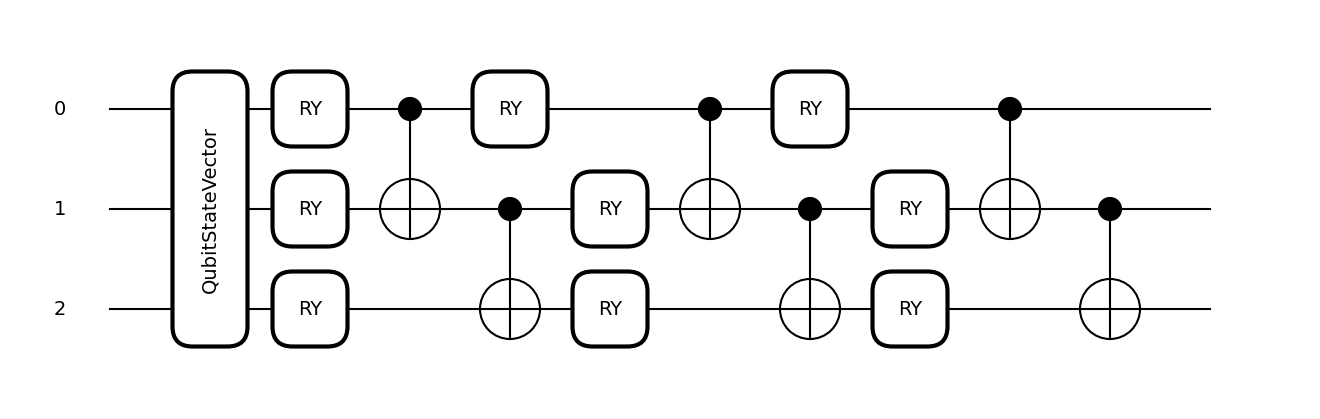

In [2]:
random_state = np.random.rand(dim)
random_state = random_state /np.linalg.norm(random_state)
qml.draw_mpl(QNN)(np.zeros(nparams),random_state)

### Model Initialization 

In [3]:
S_pItr = 6  # no. of samples used per-iteration 

nStep = 350
nItr = 100
step_size = 0.0025

Bsize = S_pItr*nItr

In [4]:
phiTrain = np.load('3-qubitsPhiTrain_v1.npy')
labelTrain = np.load('3-qubitsLabelTrain_v1.npy')

phiTrain.requires_grad = False
labelTrain.requires_grad = False

In [5]:
'QNSCD Dataset'
phiTrainNCGD = phiTrain
labelTrainNCGD = labelTrain

'SGD Dataset'
phiTrainSGD = phiTrain
labelTrainSGD = labelTrain

In [6]:
### Optimal Expected Loss
Opt_cost = []
itrBatch = np.linspace(0,Bsize*nStep,nStep,endpoint = False,dtype = 'int').tolist()
for itr1 in itrBatch:
    expOperator = 0
    for itr2 in range(Bsize):
        temp_phi = phiTrain[:,itr1+itr2]
        op = np.matmul(temp_phi.reshape(dim,1),temp_phi.reshape(1,dim))
        expOperator = expOperator + labelTrain[itr1+itr2]*op
    expOperator = expOperator/Bsize
    opt_value = 0.5*(1-sum(abs(np.linalg.svd(expOperator)[1])))
    Opt_cost.append(opt_value)

file_name = "3Q-Minimum Expected Loss"
np.save(file_name,Opt_cost)

# Optimizers

In [7]:
'QNN outputs yhat'
dev = qml.device("default.qubit", wires=nqubits, shots=1)

@qml.qnode(dev,interface='autograd')
def circuit_test(params,state):
    QNN(params,state)
    return qml.sample(qml.Hermitian(M,wires=list(range(nqubits))))

In [8]:
init_params = np.random.uniform(low=0, high=2*np.pi, size=nparams, requires_grad=True)
init_params = np.array([5.94805326, 3.24986598, 0.28734403, 3.88904246, 5.20854544, 4.82338652,
                        0.26033083, 6.07876536, 5.51526978],requires_grad = True)

'cost initialization'
phiTrain0 = phiTrain[:,-1*(Bsize+1):-1]
labelTrain0 = labelTrain[-1*(Bsize+1):-1]
temp_cost = sum([ps_expLoss(init_params,phiTrain0[:,itr],labelTrain0[itr]) for itr in range(Bsize)])/Bsize
print("Initial Average Per-Sample Expected Loss: ",temp_cost)

count = 0
for itr in range(Bsize):
    if circuit_test(init_params,phiTrain0[:,itr]) != labelTrain0[itr]:
        count += 1
temp_Ecost = count/Bsize
print("Initial Average Empirical Loss", temp_Ecost)

Initial Average Per-Sample Expected Loss:  0.7452037254875631
Initial Average Empirical Loss 0.7433333333333333


## Quantum Natural Stochastic Pairwise Coordinate Descent (2-QNSCD)

In [10]:
NCGDparams = np.array(init_params)
NCGD_cost = []
NCGD_Ecost = []

NCGD_cost.append(temp_cost)
NCGD_Ecost.append(temp_Ecost)

itrSample = np.linspace(0,Bsize,nItr,endpoint = False,dtype = 'int').tolist()
for itr1 in range(nStep):
    phiT = phiTrainNCGD[:,Bsize*itr1:Bsize*(itr1+1)]
    labelT = labelTrainNCGD[Bsize*itr1:Bsize*(itr1+1)]
    
    for itr2 in range(nItr):
        itr3 = itrSample[itr2]
        
        ### Randomly selecting a pair of coordinate
        idx = sorted(np.random.permutation(nparams)[0:2].tolist())

        ### Gradient estimation
        y1, b1 = EstGrad(NCGDparams,phiT[:,itr3],idx[0])
        y2, b2 = EstGrad(NCGDparams,phiT[:,itr3+1],idx[1])
        b1 = (1-b1)/2
        b2 = (1-b2)/2

        grad = [-1*((-1)**b1)*loss(y1,labelT[itr3]),-1*((-1)**b2)*loss(y2,labelT[itr3+1])]
        
        ### E-QFIM estimation
        metric = Est_EQFIM(NCGDparams,idx,phiT[:,itr3+2:itr3+S_pItr])

        ### double-parameters update
        NCGDparams[idx] = NCGDparams[idx] - (step_size)*np.dot(np.linalg.inv(metric),grad) 
        
    ### average per-sample expectd loss calculation
    energy = sum([ps_expLoss(NCGDparams,phiT[:,itr],labelT[itr]) for itr in range(Bsize)])/Bsize
    NCGD_cost.append(energy)
    
    ### average empirical loss calculation
    NCGDcount = 0
    for itr in range(Bsize):
        if circuit_test(NCGDparams,phiT[:,itr]) != labelT[itr]:
            NCGDcount += 1
    NCGD_Ecost.append(NCGDcount/Bsize)
    
    print("Batch count: {:2d}, Avg. per-sample expected Loss: {:.5f}".format(itr1,energy))

file_name1 = "3Q 2-QNSCD Expected Loss"
file_name2 = "3Q 2-QNSCD Empirical Loss"

np.save(file_name1,NCGD_cost)
np.save(file_name2,NCGD_Ecost)   

Batch count:  0, Avg. per-sample expected Loss: 0.74520
Batch count:  1, Avg. per-sample expected Loss: 0.72577
Batch count:  2, Avg. per-sample expected Loss: 0.72086
Batch count:  3, Avg. per-sample expected Loss: 0.72792
Batch count:  4, Avg. per-sample expected Loss: 0.72861
Batch count:  5, Avg. per-sample expected Loss: 0.71035
Batch count:  6, Avg. per-sample expected Loss: 0.71956
Batch count:  7, Avg. per-sample expected Loss: 0.70839
Batch count:  8, Avg. per-sample expected Loss: 0.69301
Batch count:  9, Avg. per-sample expected Loss: 0.69082
Batch count: 10, Avg. per-sample expected Loss: 0.66058
Batch count: 11, Avg. per-sample expected Loss: 0.65309
Batch count: 12, Avg. per-sample expected Loss: 0.66422
Batch count: 13, Avg. per-sample expected Loss: 0.62927
Batch count: 14, Avg. per-sample expected Loss: 0.62910
Batch count: 15, Avg. per-sample expected Loss: 0.60973
Batch count: 16, Avg. per-sample expected Loss: 0.59092
Batch count: 17, Avg. per-sample expected Loss: 

## Plots

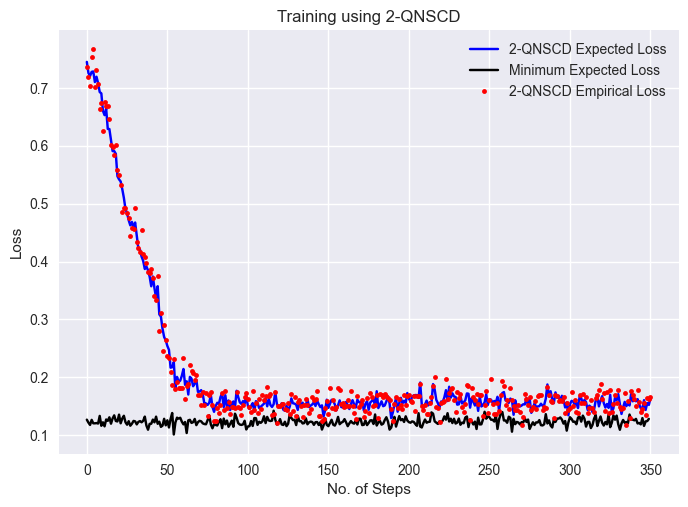

In [11]:
plt.style.use("seaborn-v0_8")
plt.plot(NCGD_cost, "b", label="2-QNSCD Expected Loss")

plt.plot(Opt_cost, "k", label="Minimum Expected Loss")
plt.plot(NCGD_Ecost, "r.", label="2-QNSCD Empirical Loss")

plt.title("Training using 2-QNSCD")
plt.ylabel("Loss")
plt.xlabel("No. of Steps")
plt.legend()
plt.show()

## 6-RQSGD using 600 samples

In [14]:
SGD6cparams = np.array(init_params)
SGD6c_cost = []
SGD6c_Ecost = []

SGD6c_cost.append(temp_cost)
SGD6c_Ecost.append(temp_Ecost)

itrSample = np.linspace(0,Bsize,nItr,endpoint = False,dtype = 'int').tolist()
for itr1 in range(nStep):
    phiT = phiTrainSGD[:,Bsize*itr1:Bsize*(itr1+1)]
    labelT = labelTrainSGD[Bsize*itr1:Bsize*(itr1+1)]
    
    for itr2 in range(nItr):
        itr3 = itrSample[itr2]
        
        ### Randomly selecting a 6 coordinates
        idx = sorted(np.random.permutation(nparams)[0:6].tolist())
        
        grad = []
        
        ### Gradient estimation
        for i_grad in range(6):
            y_hat,b = EstGrad(SGD6cparams,phiT[:,itr3+i_grad],idx[i_grad])
            b = (1-b)/2
            grad.append((-1)*((-1)**b)*loss(y_hat,labelT[itr3+i_grad]))

        ### single-parameter update
        SGD6cparams[idx] = SGD6cparams[idx] - np.dot(step_size,grad)
    
    ### average per-sample expectd loss calculation
    energy = sum([ps_expLoss(SGD6cparams,phiT[:,itr],labelT[itr]) for itr in range(Bsize)])/Bsize
    SGD6c_cost.append(energy)
    
    ### average empirical loss calculation
    SGD6ccount = 0   
    for itr in range(Bsize):
        if circuit_test(SGD6cparams,phiT[:,itr]) != labelT[itr]:
            SGD6ccount += 1
    SGD6c_Ecost.append(SGD6ccount/Bsize)
    
    print("Batch count: {:2d}, Avg. per-sample expected Loss: {:.5f}".format(itr1,energy))


file_name1 = "3Q 6-RQSGD Expected Loss"
file_name2 = "3Q 6-RQSGD Empirical Loss"

np.save(file_name1,SGD6c_cost)
np.save(file_name2,SGD6c_Ecost)

Batch count:  0, Avg. per-sample expected Loss: 0.74520
Batch count:  1, Avg. per-sample expected Loss: 0.72672
Batch count:  2, Avg. per-sample expected Loss: 0.72207
Batch count:  3, Avg. per-sample expected Loss: 0.72699
Batch count:  4, Avg. per-sample expected Loss: 0.71972
Batch count:  5, Avg. per-sample expected Loss: 0.71097
Batch count:  6, Avg. per-sample expected Loss: 0.71149
Batch count:  7, Avg. per-sample expected Loss: 0.70240
Batch count:  8, Avg. per-sample expected Loss: 0.67540
Batch count:  9, Avg. per-sample expected Loss: 0.67684
Batch count: 10, Avg. per-sample expected Loss: 0.65952
Batch count: 11, Avg. per-sample expected Loss: 0.66249
Batch count: 12, Avg. per-sample expected Loss: 0.65788
Batch count: 13, Avg. per-sample expected Loss: 0.64015
Batch count: 14, Avg. per-sample expected Loss: 0.64170
Batch count: 15, Avg. per-sample expected Loss: 0.63155
Batch count: 16, Avg. per-sample expected Loss: 0.61846
Batch count: 17, Avg. per-sample expected Loss: 

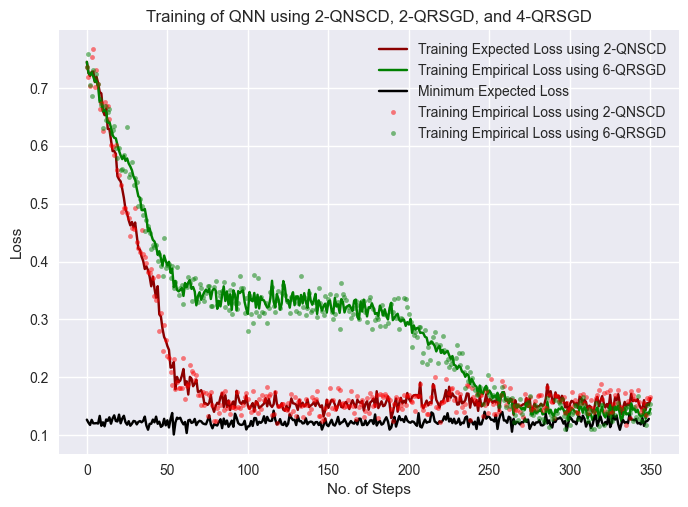

In [15]:
# plt.style.use("seaborn-v0_8")
plt.plot(NCGD_cost, "darkred", label="Training Expected Loss using 2-QNSCD")
plt.plot(SGD6c_cost, "g", label="Training Empirical Loss using 6-QRSGD")

plt.plot(Opt_cost, "k", label="Minimum Expected Loss")
plt.plot(NCGD_Ecost, "r.",alpha=0.5, label="Training Empirical Loss using 2-QNSCD")
plt.plot(SGD6c_Ecost, "g.",alpha=0.5, label="Training Empirical Loss using 6-QRSGD")


plt.title("Training of QNN using 2-QNSCD, 2-QRSGD, and 4-QRSGD")
plt.ylabel("Loss")
plt.xlabel("No. of Steps")
plt.legend()

plt.savefig('2QNSCD_6-RSGD.png')
plt.show()

## 2-RQSGD using 600 samples per step and 6 samples per itr

In [12]:
SGD6params = np.array(init_params)
SGD6_cost = []
SGD6_Ecost = []

SGD6_cost.append(temp_cost)
SGD6_Ecost.append(temp_Ecost)

itrSample = np.linspace(0,Bsize,nItr,endpoint = False,dtype = 'int').tolist()
for itr1 in range(nStep):
    phiT = phiTrainSGD[:,Bsize*itr1:Bsize*(itr1+1)]
    labelT = labelTrainSGD[Bsize*itr1:Bsize*(itr1+1)]
    
    for itr2 in range(nItr):
        itr3 = itrSample[itr2]
        
        ### Randomly selecting a 2 coordinates
        idx = sorted(np.random.permutation(nparams)[0:2].tolist())
        
        grad = []
        
        ### Gradient estimation
        y_hat01,b01 = EstGrad(SGD6params,phiT[:,itr3+0],idx[0])
        b01 = (1-b01)/2
        y_hat02,b02 = EstGrad(SGD6params,phiT[:,itr3+1],idx[0])
        b02 = (1-b02)/2
        y_hat03,b03 = EstGrad(SGD6params,phiT[:,itr3+2],idx[0])
        b03 = (1-b03)/2
        
        temp0 = ((-1)**b01)*loss(y_hat01,labelT[itr3+0]) \
              + ((-1)**b02)*loss(y_hat02,labelT[itr3+1]) \
              + ((-1)**b03)*loss(y_hat03,labelT[itr3+2])

        grad.append((-1)*temp0/3)
        
        y_hat11,b11 = EstGrad(SGD6params,phiT[:,itr3+3],idx[1])
        b11 = (1-b11)/2
        y_hat12,b12 = EstGrad(SGD6params,phiT[:,itr3+4],idx[1])
        b12 = (1-b12)/2
        y_hat13,b13 = EstGrad(SGD6params,phiT[:,itr3+5],idx[1])
        b13 = (1-b13)/2
        
        temp1 = ((-1)**b11)*loss(y_hat11,labelT[itr3+3]) \
              + ((-1)**b12)*loss(y_hat12,labelT[itr3+4]) \
              + ((-1)**b13)*loss(y_hat13,labelT[itr3+5])

        grad.append((-1)*temp1/3)

        ### single-parameter update
        SGD6params[idx] = SGD6params[idx] - np.dot(step_size,grad)
        
    ### average per-sample expectd loss calculation
    energy = sum([ps_expLoss(SGD6params,phiT[:,itr],labelT[itr]) for itr in range(Bsize)])/Bsize
    SGD6_cost.append(energy)
    
    ### average empirical loss calculation
    SGD6count = 0   
    for itr in range(Bsize):
        if circuit_test(SGD6params,phiT[:,itr]) != labelT[itr]:
            SGD6count += 1
    SGD6_Ecost.append(SGD6count/Bsize)
    
    print("Batch count: {:2d}, Avg. per-sample expected Loss: {:.5f}".format(itr1,energy))


file_name1 = "3Q 2-RQSGD_6s Expected Loss"
file_name2 = "3Q 2-RQSGD_6s Empirical Loss"

np.save(file_name1,SGD6_cost)
np.save(file_name2,SGD6_Ecost)

Batch count:  0, Avg. per-sample expected Loss: 0.74520
Batch count:  1, Avg. per-sample expected Loss: 0.73160
Batch count:  2, Avg. per-sample expected Loss: 0.73317
Batch count:  3, Avg. per-sample expected Loss: 0.74100
Batch count:  4, Avg. per-sample expected Loss: 0.73462
Batch count:  5, Avg. per-sample expected Loss: 0.72910
Batch count:  6, Avg. per-sample expected Loss: 0.73380
Batch count:  7, Avg. per-sample expected Loss: 0.72541
Batch count:  8, Avg. per-sample expected Loss: 0.71065
Batch count:  9, Avg. per-sample expected Loss: 0.71726
Batch count: 10, Avg. per-sample expected Loss: 0.70919
Batch count: 11, Avg. per-sample expected Loss: 0.71251
Batch count: 12, Avg. per-sample expected Loss: 0.71226
Batch count: 13, Avg. per-sample expected Loss: 0.71000
Batch count: 14, Avg. per-sample expected Loss: 0.70996
Batch count: 15, Avg. per-sample expected Loss: 0.70285
Batch count: 16, Avg. per-sample expected Loss: 0.70116
Batch count: 17, Avg. per-sample expected Loss: 

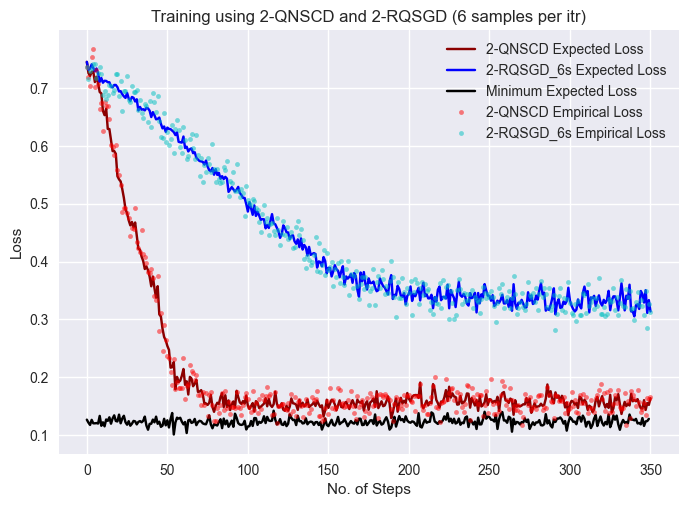

In [13]:
# plt.style.use("seaborn-v0_8")
plt.plot(NCGD_cost, "darkred", label="2-QNSCD Expected Loss")
plt.plot(SGD6_cost, "b", label="2-RQSGD_6s Expected Loss")

plt.plot(Opt_cost, "k", label="Minimum Expected Loss")
plt.plot(NCGD_Ecost, "r.",alpha=0.5, label="2-QNSCD Empirical Loss")
plt.plot(SGD6_Ecost, "c.",alpha=0.5, label="2-RQSGD_6s Empirical Loss")

plt.title("Training using 2-QNSCD and 2-RQSGD (6 samples per itr)")
plt.ylabel("Loss")
plt.xlabel("No. of Steps")
plt.legend()
plt.savefig("2RSGD_6s.png")
plt.show()

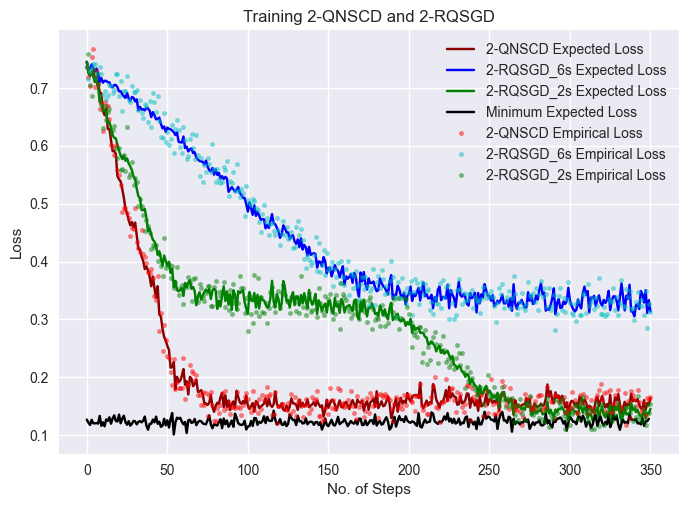

In [16]:
# plt.style.use("seaborn-v0_8")
plt.plot(NCGD_cost, "darkred", label="2-QNSCD Expected Loss")
plt.plot(SGD6_cost, "b", label="2-RQSGD_6s Expected Loss")
plt.plot(SGD6c_cost, "g", label="2-RQSGD_2s Expected Loss")

plt.plot(Opt_cost, "k", label="Minimum Expected Loss")
plt.plot(NCGD_Ecost, "r.",alpha=0.5, label="2-QNSCD Empirical Loss")
plt.plot(SGD6_Ecost, "c.",alpha=0.5, label="2-RQSGD_6s Empirical Loss")
plt.plot(SGD6c_Ecost, "g.",alpha=0.5, label="2-RQSGD_2s Empirical Loss")


plt.title("Training 2-QNSCD and 2-RQSGD")
plt.ylabel("Loss")
plt.xlabel("No. of Steps")
plt.legend()
plt.savefig("2RSGD.png")
plt.show()

## Testing Phase

In [17]:
### Saving Final Parameters:
file_name1 = "3Q 2-QNSCD params"
file_name2 = "3Q 2-RQSGD_6s params"
file_name3 = "3Q 6-RQSGD params"

np.save(file_name1,NCGDparams)
np.save(file_name2,SGD6params)
np.save(file_name3,SGD6cparams)

In [18]:
phiTest = np.load('3-qubitsPhiTest_v1.npy')
labelTest = np.load('3-qubitsLabelTest_v1.npy')

phiTest.requires_grad = False
labelTest.requires_grad = False


In [19]:
nTest = 1000

NCGDparams_opt = NCGDparams 
SGD6params_opt = SGD6params
SGD6cparams_opt = SGD6cparams

In [20]:
### Optimal Expected Loss
expOperator = 0

for i in range(nTest):
    op = np.matmul(phiTest[:,i].reshape(dim,1),phiTest[:,i].reshape(1,dim))
    expOperator = expOperator + labelTest[i]*op
expOperator = expOperator/(nTest)
opt_value = 0.5*(1+sum(abs(np.linalg.svd(expOperator)[1])))

In [21]:
NCGD_rslt = []
SGD6_rslt = []
SGD6c_rslt = []

for i in range(int(1e1)):
    NCGDcount = 0
    SGD6count = 0
    SGD6ccount = 0

    for itr in range(nTest):
        if circuit_test(NCGDparams_opt,phiTest[:,itr]) == labelTest[itr]:
            NCGDcount += 1 
        if circuit_test(SGD6params_opt,phiTest[:,itr]) == labelTest[itr]:
            SGD6count += 1
        if circuit_test(SGD6cparams_opt,phiTest[:,itr]) == labelTest[itr]:
            SGD6ccount += 1
    
    NCGD_rslt.append(NCGDcount/nTest)
    SGD6_rslt.append(SGD6count/nTest)
    SGD6c_rslt.append(SGD6ccount/nTest)
#     print("itr = ",i)

In [22]:
print("Optimal: {:.3f} \nNCGD: {:.3f} / {:.3f} max: {:.3f} min: {:.3f} \n2-RQSGD_6s: {:.3f} / {:.3f} max: {:.3f} min: {:.3f} \n6-RQSGD: {:.3f} / {:.3f} max: {:.3f} min: {:.3f}"\
      .format(opt_value,np.average(NCGD_rslt),np.std(NCGD_rslt),max(NCGD_rslt),min(NCGD_rslt),\
              np.average(SGD6_rslt),np.std(SGD6_rslt),max(SGD6_rslt),min(SGD6_rslt), \
              np.average(SGD6c_rslt),np.std(SGD6c_rslt),max(SGD6c_rslt),min(SGD6c_rslt)))

Optimal: 0.873 
NCGD: 0.846 / 0.008 max: 0.855 min: 0.825 
2-RQSGD_6s: 0.659 / 0.009 max: 0.674 min: 0.644 
6-RQSGD: 0.858 / 0.008 max: 0.869 min: 0.846
